# Example of labelling mismatch

ClippedDBSCAN will return similar clusters to vanilla DBSCAN. The labels of the clusters will probably be different, as they are randomly assigned by DBSCAN, but the members (all the core members and, in the vast majority of cases, all the border members) of a cluster that was derived by vanilla DBSCAN will be part of the same cluster when processed by ClippedDBSCAN. 

However, due to how DBSCAN operates, a border point can potentially be reached by different cluster cores. Therefore it is possible for a border point to have a non-deterministic membership, resulting in slightly different clusters even within the context of identical DBSCAN implementations with identical parameter values, but with different evaluation routes.

This notebook generates such a situation.

In [1]:
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets.samples_generator import make_blobs

from helpers.labels import Labels

### Generate data

In [2]:
centers = [(-2, -2), (0, 0), (4.2, 5)]
X, y = make_blobs(n_samples=20000, centers=centers, n_features=2, random_state=0)

### Rounding and clustering parameters

In [3]:
radius = 0.1
min_samples = 15
round_decimals = 1

## DBSCAN without subsampling

In [4]:
from sklearn.preprocessing import FunctionTransformer

In [5]:
pipeline_noClip = make_pipeline(StandardScaler(), 
                                FunctionTransformer(np.round, 
                                                    validate=False, 
                                                    kw_args={"decimals": round_decimals}),
                                DBSCAN(eps=radius, min_samples=min_samples))
labels_noClip = pipeline_noClip.fit_predict(X)
labels_noClip = Labels('noClip', labels_noClip)

## DBSCAN with subsampling

In [6]:
from gridrep import cluster

In [7]:
pipeline_clip = make_pipeline(StandardScaler(), 
                              cluster.ClippedDBSCAN(eps=radius,
                                                    min_samples=min_samples,
                                                    round_decimals=round_decimals))
labels_clip = pipeline_clip.fit_predict(X)
labels_clip = Labels('clip', labels_clip)

### Compare labels

In [8]:
from helpers.labels import where_not_all_match

In [9]:
noClip_clip = where_not_all_match(labels_noClip, labels_clip)
clip_noClip = where_not_all_match(labels_clip, labels_noClip)

In [10]:
from helpers.labels import scatter_from_mismatch

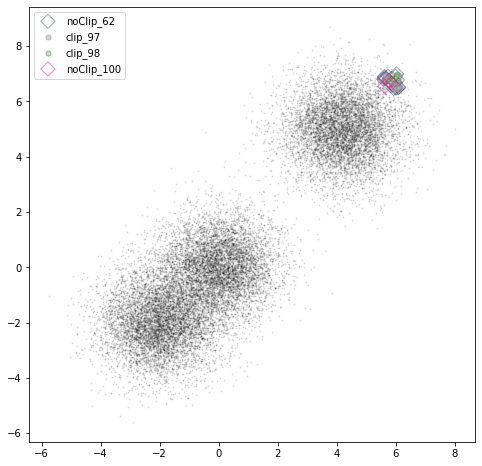

In [11]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], s=1, c='k', alpha=0.1)

plotted1 = scatter_from_mismatch(labels_noClip, labels_clip, noClip_clip, X)
plotted2 = scatter_from_mismatch(labels_clip,labels_noClip, clip_noClip, X, excluded=plotted1)

plt.legend()

title = '_'.join(map(str, ['min_samples', min_samples, 
                           'radius', radius, 
                           'decimals', round_decimals]))
# plt.savefig(title+'_border_mismatch.png', dpi=300, bbox_inches='tight')
plt.show()

### Time

In [12]:
%%timeit
pipeline_noClip.fit_predict(X)

310 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
pipeline_clip.fit_predict(X)

59.3 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
